# Audio Genre Classification with Convolutional Neural Networks in PyTorch 

## Goal

The goal of this notebook is to implement a Convolutional Neural Network (CNN) using the PyTorch package for classifying music genres. To do this we will use the GTZAN dataset which was originally created for the paper "Musical genre classification of audio signals" by Tzanetakis and Cook.

The GTZAN dataset consists of 100 30-second samples in each of the 10 music genres with corresponding labels. The original paper classifies genres using statistical pattern recognition methods such as Gaussian mixture models or K-nearest neighbors on hand constructed features. They report a classification accuracy of 61%, which they say is comparable to human musical genre classification. In this notebook we show that simple CNN's, requiring no more computing power than offered by a laptop, can outperform these earlier methods.

## CNN Input

For the input to our CNN, we will convert the audio data into its spectrogram, which is simply many Fourier transforms over small overlapping time windows. These are then stacked together to form a heatmap of frequency content vs. time, i.e. frequency images containing one color channel.

The data can be generated by the create_spectrograms.ipynb file, included in the GitHub repository. This will create 10 genre folders containting 1000 spectrograms each. Here we have augmented our data by splitting 30-second audio clips into 3-second audio clips, increasing our dataset by a factor of 10, which greatly increases our CNN's recognition ability.

## CNN Architecture

We have found that a very simple architecture gives the best classification accuracy. Our final architecture consists of a single 2D convolution layer of depth N, a MaxPool layer, a BatchNorm layer, followed by a fully connected layer, and lastly a soft max classifier.

We borrow extensively from the procedures and methods developed in this course, especially NB14.

## Results

We obtain a testing accuracy of up to 92% on our simple architecture, much greater than the 61% reported by Tzanetakis and Cook. The parameters we varied were the depth of the convolutional layer, the optimal depth being $N=5$. We also varied the optimizer, where ADAM performed the best over SGD, with negligble performance increase in varying its default parameters.

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs

from PIL import Image, ImageOps
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
from torchvision import transforms as T

### Step 1: Load and Process the Spectrogram Dataset

We start by defining the dataset class for Pytorch.

To proceed with the cells below, you must first generate the dataset by running the create_spectrograms.ipnyb file given in the repository. If this is run in the same directory as this notebook, all cells below will work without the need to modify paths.

In [47]:
from torchvision import datasets # load data

class Genre_Dataset(torch.utils.data.Dataset):
    """GTZAN spectrograms pytorch dataset."""

    def __init__(self, data_type, transform=False):
        """
        Args:
            data_type (string): `train` or `test` : creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.

        """

        from sklearn.model_selection import train_test_split
        import collections

        directory = "mel_spectrograms_3sec/"

        genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae', 'rock', 'jazz']
        
        X = []
        Y = []
        
        transforms = torch.nn.Sequential(
            T.RandomCrop(50),
            T.Pad(50),
            T.RandomHorizontalFlip(p=0.3),
        )

        for index, g in enumerate(genres):
            filenames = os.listdir(os.path.join(directory,g))
    
            for f in filenames:
                img = Image.open(directory + g + '/' + f)
                img = ImageOps.crop(img, (0,1,0,0))
                img = ImageOps.grayscale(img)
                data = np.array(img)
                X.append(data.flatten())
                Y.append(index)
                
                img.close()
        
        X = np.array(X)
        Y = np.array(Y)

        # pick random data points from ordered and disordered states to create the training and test sets
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8)

        if data_type=='train':
            X=X_train
            Y=Y_train
            print("Training on 80 percent of examples")

        if data_type=='test':
            X=X_test
            Y=Y_test
            print("Testing on 20 percent of examples")

        X=X.reshape(X.shape[0],334,216)

        # these are necessary attributes in dataset class and must be assigned
        self.data=(X,Y)
        self.transform = transform

    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)

        return sample

def load_data(kwargs):
    # kwargs:  CUDA arguments, if enabled
    # load and noralise train,test, and data
    train_loader = torch.utils.data.DataLoader(
        Genre_Dataset(data_type='train'),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        Genre_Dataset(data_type='test'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

We define the architecture of the neural net in the `model` class which contains the `forward` function method that tells us how to produce the output given some input. The backpropagaiton algorithm is implemented automatically by the Pytorch package.

A CNN is composed of convolutional layers, max-pool layer, often followed by a fully connected layer and then the classifier. In the architecture below, we start with a convolutional layer that takes as an input a layer with $D_{in}=1$ with height and width of our spectrograms $H=334, W=216$, a receptive field or filter size of $2 \times 2$, and depth $N$ (there are $N$ layers). We also add a padding of zeros on both sides of the image.  This convolutional layer can be summarized by the four numbers $[N,D_{in},H,W]=[N,1,335,217]$. This is then fed into a $2 \times 2$ maxpool layer which results in layer of size $[N,1,167,108]$. This layer is then hooked up to a linear layer that takes as an `[input,output]` of the form `[N*167*108*1,10]` since there are $10$ genres to distinguish. We use a logistic (softmax) classifier as the output and train using various optimizers.

In [48]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer
        self.fc1 = nn.Linear(167*108*N, 10)
        self.N=N
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,334,216) to (:,1,334,216)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) #batch norm
        return F.log_softmax(self.fc1(x.view(-1,167*108*self.N)), dim=1)

### View architecture summary

This only shows the __init__ architecture, not the forward function.

In [52]:
from torchsummary import summary

CNN = model(N=5)
summary(CNN, (334, 216))

The number of neurons in CNN layer is 5
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 335, 217]              25
       BatchNorm2d-2          [-1, 5, 167, 108]              10
            Linear-3                   [-1, 10]         901,810
Total params: 901,845
Trainable params: 901,845
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.28
Forward/backward pass size (MB): 3.46
Params size (MB): 3.44
Estimated Total Size (MB): 7.18
----------------------------------------------------------------


#### Define the `train` and `test` functions

These are very standard functions for going over data to train and evaluate the model. 

Since we will be testing the CNN performance on both the test and the critical data, the `test` function accepts two arguments: `data_loader` and `verbose` to allow control over the input data and the printing messages.

In [82]:
def train(epoch):
    # these are very standard functions for going over data to train

    CNN.train() # effects Dropout and BatchNorm layers
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = CNN(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader,verbose='Test'):
    # these are very standard functions for evaluating data

    CNN.eval() # effects Dropout and BatchNorm layers
    test_loss = 0
    correct = 0
    targets = []
    predictions = []
    
    for data, target in data_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        output = CNN(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        targets.append(target)
        predictions.append(pred)

    test_loss /= len(data_loader.dataset)
    print('\n'+verbose+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    accuracy=100. * correct / len(data_loader.dataset)
    return(accuracy, targets, predictions)

#### Define Model Parameters

Next we define the training settings.

In [50]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model.

In [141]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
#train_loader, test_loader, critical_loader=load_data(cuda_kwargs)
train_loader, test_loader = load_data(cuda_kwargs)

test_array=[]
#confusion = []

# create array of depth of convolutional layer
#N_array=[1,5,10,20,50]
N_array=[5]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    #optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer = optim.Adam(CNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            accuracy, targets, predictions = test(test_loader,verbose='Test')
            test_array.append(accuracy)
            #critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            #test(critical_loader,verbose='Critical')
    print(test_array)
    #print(critical_array)

Training on 80 percent of examples
Testing on 20 percent of examples
The number of neurons in CNN layer is 5
Train Epoch: 1 [0/8000 (0%)]	Loss: 2.391875
Train Epoch: 1 [640/8000 (8%)]	Loss: 16.932661
Train Epoch: 1 [1280/8000 (16%)]	Loss: 9.667825
Train Epoch: 1 [1920/8000 (24%)]	Loss: 5.324150
Train Epoch: 1 [2560/8000 (32%)]	Loss: 5.173895
Train Epoch: 1 [3200/8000 (40%)]	Loss: 3.706764
Train Epoch: 1 [3840/8000 (48%)]	Loss: 3.155435
Train Epoch: 1 [4480/8000 (56%)]	Loss: 2.363208
Train Epoch: 1 [5120/8000 (64%)]	Loss: 2.759436
Train Epoch: 1 [5760/8000 (72%)]	Loss: 1.541110
Train Epoch: 1 [6400/8000 (80%)]	Loss: 2.657563
Train Epoch: 1 [7040/8000 (88%)]	Loss: 3.184101
Train Epoch: 1 [7680/8000 (96%)]	Loss: 1.676077

Test set: Average loss: 1.2233, Accuracy: 1482/2000 (74%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 1.099169
Train Epoch: 2 [640/8000 (8%)]	Loss: 0.878931
Train Epoch: 2 [1280/8000 (16%)]	Loss: 0.454980
Train Epoch: 2 [1920/8000 (24%)]	Loss: 1.011800
Train Epoch: 2 [2560/8000 

### Confusion Matrix

In [162]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [163]:
targs = []
preds = []
for tensor in targets:
    for t in tensor:
        targs.append(int(t))
for tensor in predictions:
    for t in tensor:
        preds.append(int(t))

In [168]:
cf_matrix = confusion_matrix(targs, preds, normalize='true')

[Text(84.453125, 0.5, 'True Label'),
 Text(0.5, 39.453125, 'Predicted Label'),
 Text(0.5, 1.0, 'Confusion Matrix')]

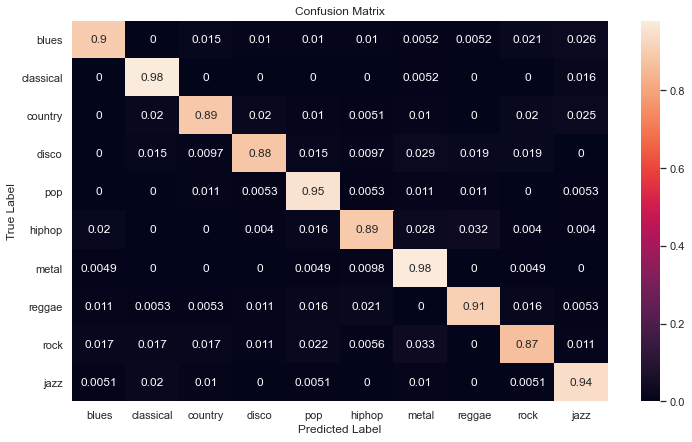

In [169]:
df = pd.DataFrame(cf_matrix, index = [i for i in genres], 
                  columns = [i for i in genres])
ax = sn.heatmap(df, annot=True)
sn.set(rc={"figure.figsize":(12, 7)})
ax.set(xlabel='Predicted Label',
       ylabel='True Label',
       title='Confusion Matrix')